In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.inspection import permutation_importance
import shap
from sklearn.linear_model import LassoCV
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


# Các hàm

## 1. Load dữ liệu

In [2]:
USER_STATIC_COLS = [
    'user_year', 'user_month', 'user_past_course_count', 'remaining_time',
    'user_time_since_last_course', 'school'
]
COURSE_FEATURE_COLS = [
    'start_year', 'start_month', 'end_year', 'end_month', 'field_encoded_1', 'field_encoded_2', 
    'video_count', 'exercise_count','chapter_count', 'num_prerequisites', 'certificate',
    'assignment', 'video', 'exam', 'duration_days'
]
USER_DYNAMIC_PREFIXES = [
    'entropy_time_comment_phase', 'exercise_correct_sum_', 'exercise_correct_mean_',
    'exercise_attempts_mean_mean_', 'exercise_date_from_enroll_min_',
    'exercise_date_from_enroll_max_', 'exercise_context_mean_',
    'exercise_langugage_binary_mean_', 'exercise_diff_min_', 'exercise_diff_max_',
    'exercise_perc_goal_score_mean_', 'exercise_perc_real_completed_mean_',
    'exercise_perc_real_completed_std_', 'exercise_perc_real_correct_std_',
    'exercise_hour_entropy_', 'video_watched_percentage_', 'video_pause_std_',
    'video_rewatch_avg_', 'video_rewatch_std_', 'video_time_between_views_avg_',
    'video_time_between_views_std_', 'total_words_phase', 'total_positive',
    'total_negative', 'total_neutral', 
]

In [3]:
def extract_dynamic_features(df):
    dynamic_cols = []
    for prefix in USER_DYNAMIC_PREFIXES:
        dynamic_cols += [col for col in df.columns if col.startswith(prefix)]
    return dynamic_cols


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
import numpy as np
import pandas as pd

def scale_data(X_train, scaler_type="standard"):
    if scaler_type == "minmax":
        scaler = MinMaxScaler()
    elif scaler_type == "standard":
        scaler = StandardScaler()
    elif scaler_type == "robust":
        scaler = RobustScaler()
    elif scaler_type == "log":
        # Ensure all values are > 0 before log transform
        if (X_train <= 0).any().any():
            X_train = X_train + 1 - X_train.min().min()
        return np.log(X_train), np.log(X_test)
    else:
        raise ValueError("Scaler type not recognized")

    scaler.fit(X_train)
    return scaler.transform(X_train), scaler


In [5]:
def load_and_preprocess_data(csv_path, scale='standard'):
    df = pd.read_csv(csv_path)

    # Drop unused columns
    df = df.drop(['total_score', 'label', 'type'], axis=1, errors='ignore')

    # Encode categorical
    count_map = df['school'].value_counts().to_dict()
    df['school'] = df['school'].map(count_map).fillna(0)
    df = df.fillna(0)

    # Encode labels
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label_encoded'])

    # Course features
    course_df = df.drop_duplicates('course_id')[['course_id'] + COURSE_FEATURE_COLS].copy()
    course_df = course_df.set_index('course_id')
    course_feat_scaled, course_scaler = scale_data(course_df, scale)
    course_df_scaled = pd.DataFrame(course_feat_scaled, index=course_df.index, columns=course_df.columns)

    # User features
    dynamic_cols = extract_dynamic_features(df)
    user_features = df[USER_STATIC_COLS + dynamic_cols]
    user_feat_scaled, user_scaler = scale_data(user_features, scale)
    user_features_scaled = pd.DataFrame(user_feat_scaled, index=df.index)

    return (
        df,
        user_features_scaled,
        course_df_scaled,
        df['label_encoded'].values,
        course_scaler,
        user_scaler,
        count_map
    )

## 2. Đánh giá dữ liệu

### GNN Explainer

In [6]:
import torch
print(torch.__version__)

2.5.1+cu124


In [7]:
pip uninstall torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -y

Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install torch-geometric \
  torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html \
  torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html \
  torch-cluster -f https://data.pyg.org/whl/torch-2.5.1+cu124.html \
  torch-spline-conv -f https://data.pyg.org/whl/torch-2.5.1+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html, https://data.pyg.org/whl/torch-2.5.1+cu124.html, https://data.pyg.org/whl/torch-2.5.1+cu124.html, https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00


In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
import torch_geometric
print(torch_geometric.__version__)

2.6.1


In [11]:
from torch_geometric.explain.algorithm import GNNExplainer

def explain_node(model, data, node_idx, feature_names):
    model.eval()
    explainer = GNNExplainer(model=model, epochs=200)
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)

    # Plot feature importance
    ax = explainer.visualize_feature_importance(node_feat_mask, feature_names=feature_names)
    ax.set_title(f"Feature Importance for Node {node_idx}")

    # Plot subgraph
    explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y=data.y[node_idx])

# 1. Scale dữ liệu standard

In [12]:
from sklearn.neighbors import NearestNeighbors

def add_user_similarity_edges(user_features, threshold=0.9, top_k=10):
    nbrs = NearestNeighbors(n_neighbors=top_k+1, metric='cosine').fit(user_features)
    distances, indices = nbrs.kneighbors(user_features)

    edge_list = []
    for i in range(len(user_features)):
        for j, d in zip(indices[i][1:], distances[i][1:]):  # skip self (index 0)
            similarity = 1 - d
            if similarity > threshold:
                edge_list.append([i, j])
    return edge_list

In [13]:
def build_graph(df, user_features, course_features, cosine_threshold=0.9, top_k=10):
    edge_index = []
    user_indices = df.index
    
    # Add user-user similarity edges
    user_sim_edges = add_user_similarity_edges(user_features, threshold=cosine_threshold, top_k=top_k)
    for i, j in user_sim_edges:
        edge_index.append([i, j])

    # Map course IDs to new indices
    course_id_map = {cid: i + len(user_indices) for i, cid in enumerate(course_features.index)}

    # Add student-course edges
    for idx, row in df.iterrows():
        course_idx = course_id_map[row['course_id']]
        edge_index.append([idx, course_idx])
        edge_index.append([course_idx, idx])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Combine features
    x_user = torch.tensor(user_features.values, dtype=torch.float)
    x_course = torch.tensor(course_features.values, dtype=torch.float)

    # Ensure both feature matrices have the same number of columns
    user_dim, course_dim = x_user.shape[1], x_course.shape[1]
    if user_dim > course_dim:
        pad_width = user_dim - course_dim
        x_course = F.pad(x_course, (0, pad_width))  # Pad the course features on the last dimension
    elif course_dim > user_dim:
        pad_width = course_dim - user_dim
        x_user = F.pad(x_user, (0, pad_width))

    x = torch.cat([x_user, x_course], dim=0)

    return x, edge_index, len(user_indices)

In [14]:
# 3. GAT Model
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, heads=2):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim * heads, num_classes, heads=1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

In [15]:
# 4. Train model

def train_model(model, data, train_mask, test_mask, y_true, num_users_train, num_epochs=600):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.006, weight_decay=5e-4)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)

        out_user = out[:num_users_train]  # Only user nodes
        loss = F.cross_entropy(out_user[train_mask], y_true[train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                _, pred = out_user[test_mask].max(dim=1)
                acc = pred.eq(y_true[test_mask]).sum().item() / test_mask.sum().item()
                print(f"Epoch {epoch} | Validation Accuracy: {acc:.4f}")

    return model

In [16]:
from sklearn.preprocessing import label_binarize

def evaluate(model, data, mask, y_true, phase, set_name="Test", scale='standard', num_users=None):
    model.eval()
    out = model(data.x, data.edge_index)

    # Only keep user node outputs
    if num_users is not None:
        out = out[:num_users]

    logits = out[mask]
    preds = torch.argmax(logits, dim=1)
    labels = y_true[mask]

    # 📝 Classification report
    print(f"\n📊 Classification Report ({set_name} Set):")
    print(classification_report(labels.cpu(), preds.cpu()))

    # 📉 Confusion Matrix
    cm = confusion_matrix(labels.cpu(), preds.cpu())
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{set_name} Set Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # 🎯 AUC and ROC
    n_classes = len(torch.unique(y_true))
    y_bin = label_binarize(labels.cpu(), classes=list(range(n_classes)))
    y_score = logits.detach().cpu().numpy()

    try:
        aucs = []
        for i in range(n_classes):
            roc_auc = roc_auc_score(y_bin[:, i], y_score[:, i])
            aucs.append(roc_auc)
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{set_name} ROC Curves")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Average AUC ({set_name}): {np.mean(aucs):.4f}")
    except Exception as e:
        print(f"⚠️ AUC could not be computed: {e}")

    # Save results
    df_save = pd.DataFrame({
        'true_label': labels.cpu().numpy(),
        'predicted_label': preds.cpu().numpy()
    })
    df_features = pd.DataFrame(data.x[:num_users][mask].cpu().numpy())
    df_result = pd.concat([df_save, df_features], axis=1)
    save_path = f'result_{phase}_{set_name}_{scale}.csv'
    df_result.to_csv(save_path, index=False)
    print(f"✅ Saved predictions and features to {save_path}")


In [17]:
# 6. Pipeline

def run_pipeline(csv_path, test_csv_path, phase, scale = 'standard'):
    print('load data train')
    df_train, user_feat_train, course_feat_train, labels_train, course_scaler, user_scaler, count_map = load_and_preprocess_data(csv_path, scale = scale)

    print('build the graph')
    # Build training graph
    x_train, edge_index_train, num_users_train = build_graph(df_train, user_feat_train, course_feat_train, cosine_threshold=0.9)
    y_train = torch.tensor(labels_train, dtype=torch.long)
    # train_idx, test_idx = train_test_split(np.arange(num_users), test_size=0.2, stratify=labels, random_state=42)

    # ⚠️ Only use labels of user nodes!
    y_train = torch.tensor(labels_train[:num_users_train], dtype=torch.long)
    
    train_idx, val_idx = train_test_split(np.arange(num_users_train), test_size=0.1, stratify=y_train, random_state=42)
    train_mask = torch.zeros(num_users_train, dtype=torch.bool)
    val_mask = torch.zeros(num_users_train, dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True

    print("Total nodes in graph:", x_train.shape[0])
    print("User nodes (labels):", num_users_train)
    print("Label tensor shape:", y_train.shape)
    
    # train_idx, val_idx = train_test_split(np.arange(num_users_train), test_size=0.1, stratify=labels_train, random_state=42)
    # num_nodes_train = x_train.shape[0]
    # train_mask = torch.zeros(num_nodes_train, dtype=torch.bool)
    # val_mask = torch.zeros(num_nodes_train, dtype=torch.bool)
    # train_mask[train_idx] = True
    # val_mask[val_idx] = True

    print('train')
    data_train = Data(x=x_train, edge_index=edge_index_train, y=y_train)
    model = GAT(input_dim=x_train.shape[1], hidden_dim=64, num_classes=len(np.unique(labels_train)))
    model = train_model(model, data_train, train_mask, val_mask, y_train, num_users_train = num_users_train)
    
    print('load test')
    # Load test data with scalers
    df_test = pd.read_csv(test_csv_path)
    df_test.drop(['total_score', 'label', 'type'], axis =1)
    df_test['school'] = df_test['school'].map(count_map).fillna(0)
    df_test = df_test.fillna(0)
    le = LabelEncoder()
    df_test['label_encoded'] = le.fit_transform(df_test['label_encoded'])
    

    # Scale features using training scalers
    course_df_test = df_test.drop_duplicates('course_id')[['course_id'] + COURSE_FEATURE_COLS].set_index('course_id')
    course_feat_test = pd.DataFrame(course_scaler.transform(course_df_test), index=course_df_test.index)

    dynamic_cols = extract_dynamic_features(df_test)
    user_feat_test = pd.DataFrame(user_scaler.transform(df_test[USER_STATIC_COLS + dynamic_cols]), index=df_test.index)

    print('build test graph')
    # Build test graph and evaluate
    x_test, edge_index_test, num_users_test = build_graph(df_test, user_feat_test, course_feat_test, cosine_threshold=0.9)
    y_test = torch.tensor(df_test['label_encoded'].values, dtype=torch.long)
    test_mask = torch.ones(num_users_test, dtype=torch.bool)

    data_test = Data(x=x_test, edge_index=edge_index_test, y=y_test)
    print('evalate')
    evaluate(model, data_train, train_mask, y_train, phase=phase, set_name="Train", scale=scale, num_users=num_users_train)
    evaluate(model, data_train, val_mask, y_train, phase= phase, set_name="Validation", scale=scale, num_users=num_users_train)
    evaluate(model, data_test, test_mask, y_test, phase = phase, set_name="Test", scale=scale, num_users=num_users_test)


phase1
load data train
build the graph
Total nodes in graph: 10781
User nodes (labels): 10570
Label tensor shape: torch.Size([10570])
train
Epoch 0 | Validation Accuracy: 0.1788
Epoch 10 | Validation Accuracy: 0.6575
Epoch 20 | Validation Accuracy: 0.6783
Epoch 30 | Validation Accuracy: 0.6859
Epoch 40 | Validation Accuracy: 0.6831
Epoch 50 | Validation Accuracy: 0.6954
Epoch 60 | Validation Accuracy: 0.6973
Epoch 70 | Validation Accuracy: 0.7010
Epoch 80 | Validation Accuracy: 0.6991
Epoch 90 | Validation Accuracy: 0.6973
Epoch 100 | Validation Accuracy: 0.7020
Epoch 110 | Validation Accuracy: 0.7048
Epoch 120 | Validation Accuracy: 0.7058
Epoch 130 | Validation Accuracy: 0.7077
Epoch 140 | Validation Accuracy: 0.7086
Epoch 150 | Validation Accuracy: 0.7086
Epoch 160 | Validation Accuracy: 0.7086
Epoch 170 | Validation Accuracy: 0.7077
Epoch 180 | Validation Accuracy: 0.7020
Epoch 190 | Validation Accuracy: 0.7067
Epoch 200 | Validation Accuracy: 0.7096
Epoch 210 | Validation Accuracy

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


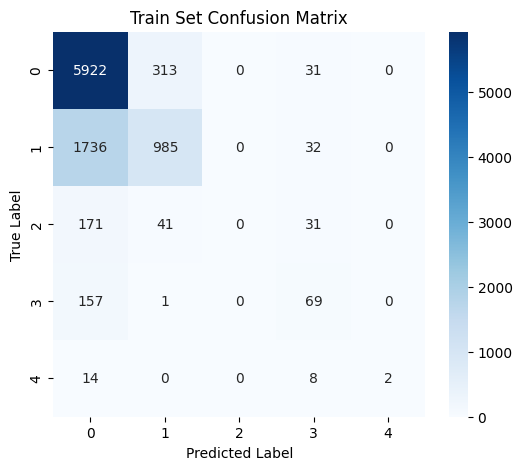

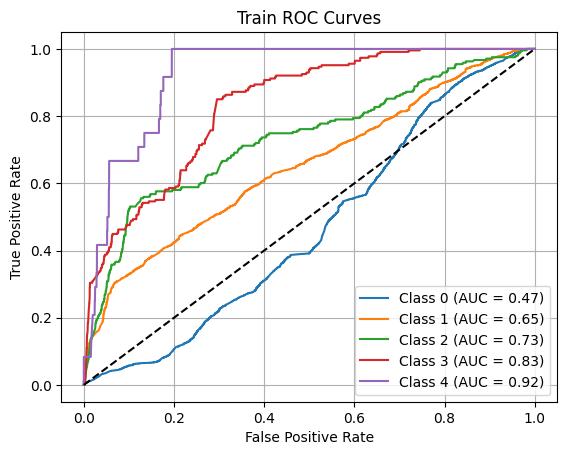

Average AUC (Train): 0.7220
✅ Saved predictions and features to result_phase1_Train_standard.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.73      0.95      0.83       696
           1       0.76      0.32      0.45       306
           2       0.00      0.00      0.00        27
           3       0.18      0.16      0.17        25
           4       0.00      0.00      0.00         3

    accuracy                           0.72      1057
   macro avg       0.33      0.29      0.29      1057
weighted avg       0.71      0.72      0.68      1057



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


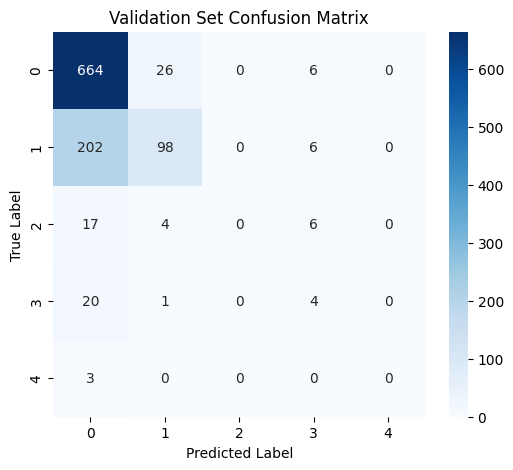

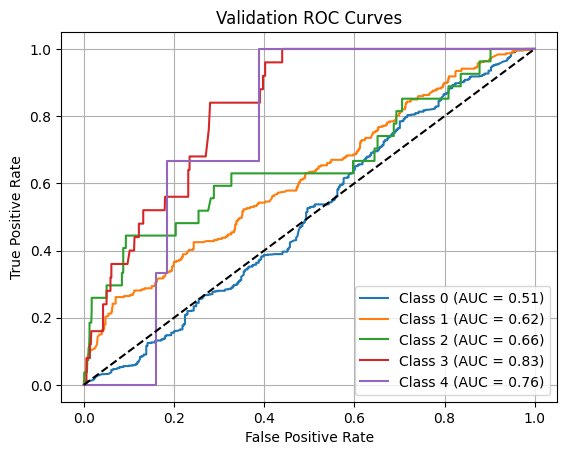

Average AUC (Validation): 0.6729
✅ Saved predictions and features to result_phase1_Validation_standard.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       616
           1       0.30      0.37      0.33        94
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        10

    accuracy                           0.69       756
   macro avg       0.23      0.23      0.23       756
weighted avg       0.74      0.69      0.71       756



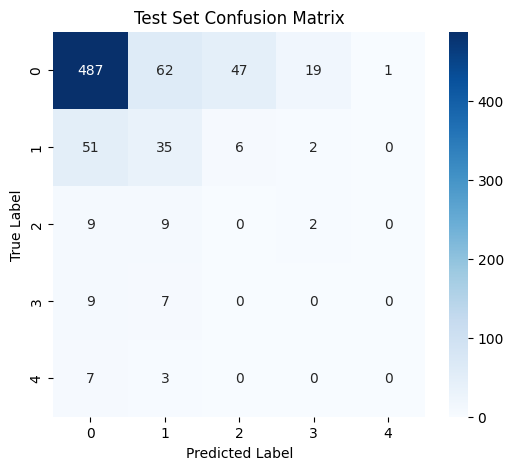

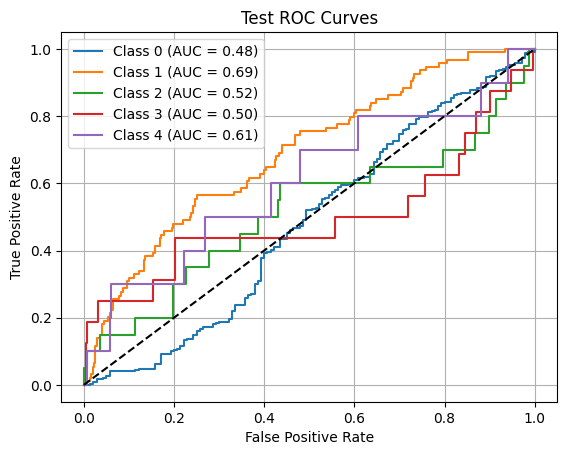

Average AUC (Test): 0.5576
✅ Saved predictions and features to result_phase1_Test_standard.csv
phase2
load data train
build the graph
Total nodes in graph: 8742
User nodes (labels): 8548
Label tensor shape: torch.Size([8548])
train
Epoch 0 | Validation Accuracy: 0.1637
Epoch 10 | Validation Accuracy: 0.6550
Epoch 20 | Validation Accuracy: 0.6807
Epoch 30 | Validation Accuracy: 0.6795
Epoch 40 | Validation Accuracy: 0.6854
Epoch 50 | Validation Accuracy: 0.6877
Epoch 60 | Validation Accuracy: 0.6854
Epoch 70 | Validation Accuracy: 0.6901
Epoch 80 | Validation Accuracy: 0.6889
Epoch 90 | Validation Accuracy: 0.6959
Epoch 100 | Validation Accuracy: 0.7018
Epoch 110 | Validation Accuracy: 0.7076
Epoch 120 | Validation Accuracy: 0.7053
Epoch 130 | Validation Accuracy: 0.7041
Epoch 140 | Validation Accuracy: 0.7041
Epoch 150 | Validation Accuracy: 0.7064
Epoch 160 | Validation Accuracy: 0.7146
Epoch 170 | Validation Accuracy: 0.7123
Epoch 180 | Validation Accuracy: 0.7123
Epoch 190 | Validat

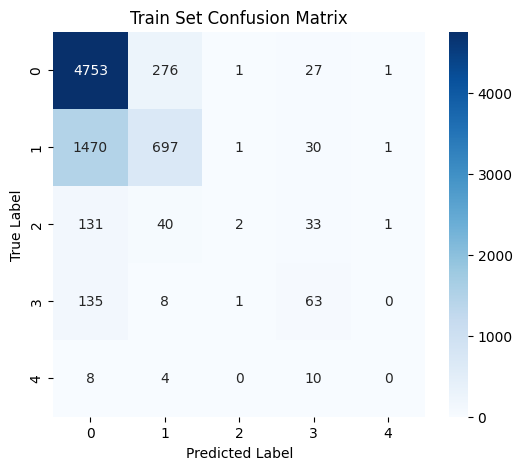

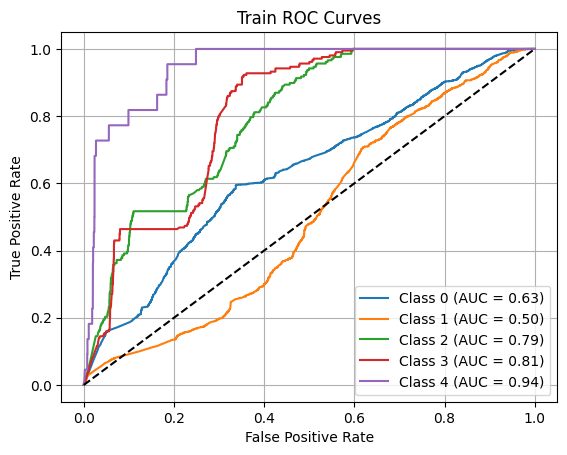

Average AUC (Train): 0.7348
✅ Saved predictions and features to result_phase2_Train_standard.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       562
           1       0.67      0.31      0.43       244
           2       0.00      0.00      0.00        23
           3       0.40      0.26      0.32        23
           4       0.00      0.00      0.00         3

    accuracy                           0.72       855
   macro avg       0.36      0.30      0.31       855
weighted avg       0.68      0.72      0.67       855



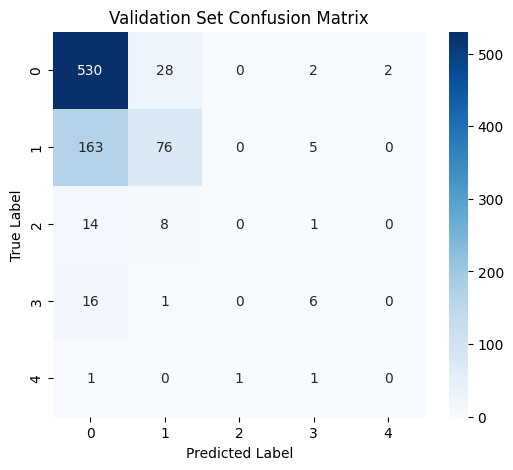

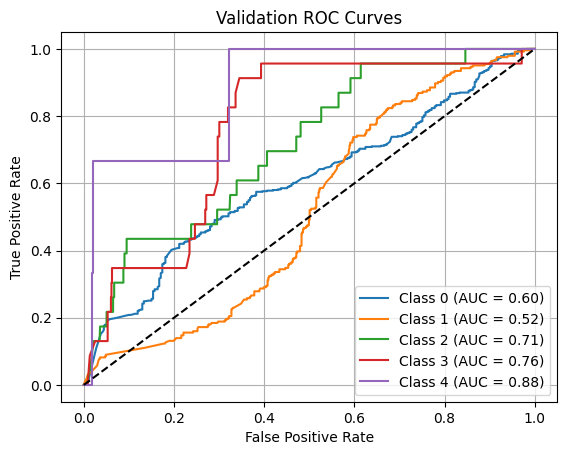

Average AUC (Validation): 0.6951
✅ Saved predictions and features to result_phase2_Validation_standard.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       609
           1       0.13      0.08      0.10        92
           2       0.00      0.00      0.00        20
           3       0.25      0.07      0.11        15
           4       0.00      0.00      0.00        10

    accuracy                           0.77       746
   macro avg       0.24      0.22      0.22       746
weighted avg       0.70      0.77      0.73       746



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


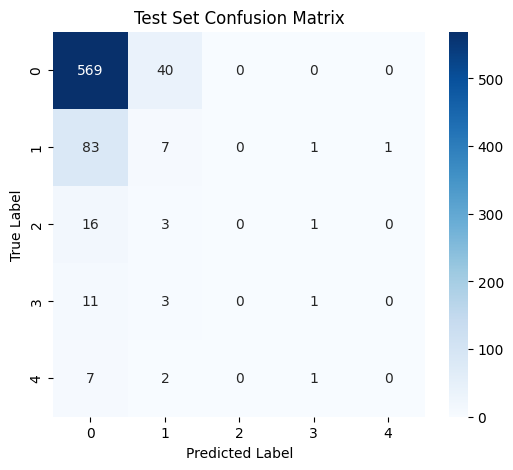

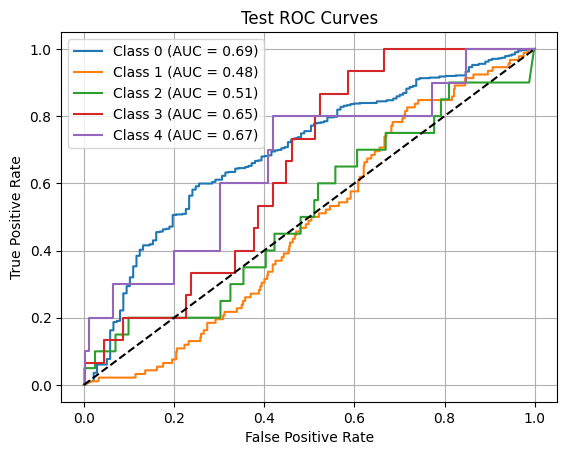

Average AUC (Test): 0.5993
✅ Saved predictions and features to result_phase2_Test_standard.csv
phase3
load data train
build the graph
Total nodes in graph: 7970
User nodes (labels): 7803
Label tensor shape: torch.Size([7803])
train
Epoch 0 | Validation Accuracy: 0.3380
Epoch 10 | Validation Accuracy: 0.6633
Epoch 20 | Validation Accuracy: 0.6914
Epoch 30 | Validation Accuracy: 0.6914
Epoch 40 | Validation Accuracy: 0.6953
Epoch 50 | Validation Accuracy: 0.6927
Epoch 60 | Validation Accuracy: 0.6953
Epoch 70 | Validation Accuracy: 0.6978
Epoch 80 | Validation Accuracy: 0.7055
Epoch 90 | Validation Accuracy: 0.7081
Epoch 100 | Validation Accuracy: 0.7106
Epoch 110 | Validation Accuracy: 0.7106
Epoch 120 | Validation Accuracy: 0.7119
Epoch 130 | Validation Accuracy: 0.7119
Epoch 140 | Validation Accuracy: 0.7119
Epoch 150 | Validation Accuracy: 0.7081
Epoch 160 | Validation Accuracy: 0.7068
Epoch 170 | Validation Accuracy: 0.7081
Epoch 180 | Validation Accuracy: 0.7081
Epoch 190 | Validat

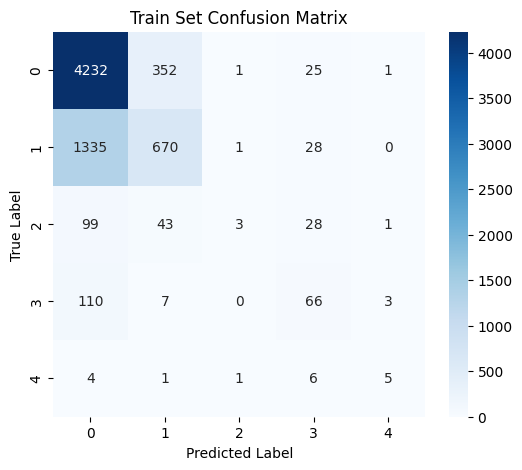

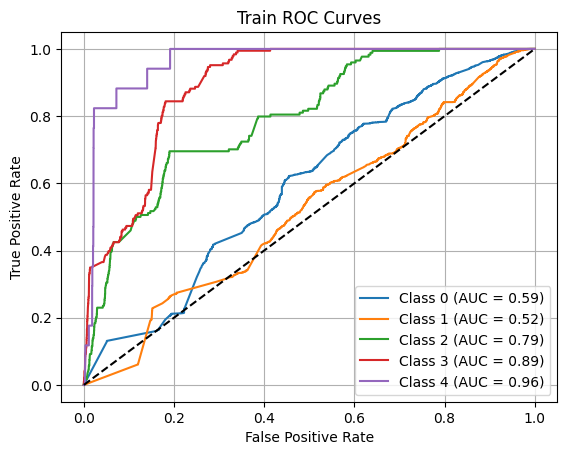

Average AUC (Train): 0.7519
✅ Saved predictions and features to result_phase3_Train_standard.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       513
           1       0.60      0.32      0.42       226
           2       0.00      0.00      0.00        19
           3       0.40      0.29      0.33        21
           4       0.00      0.00      0.00         2

    accuracy                           0.71       781
   macro avg       0.35      0.31      0.31       781
weighted avg       0.67      0.71      0.67       781



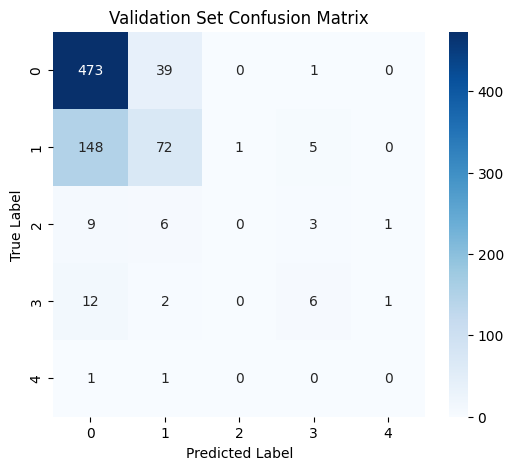

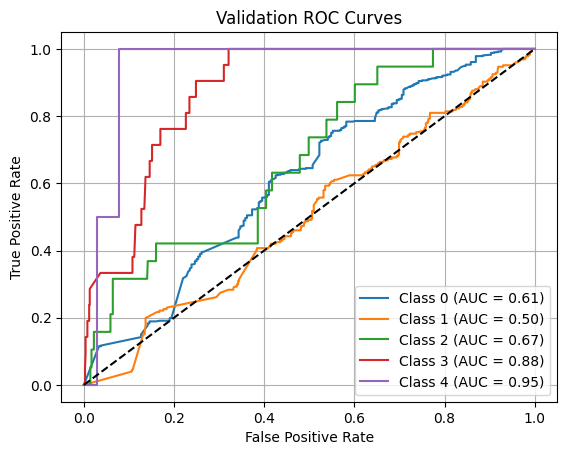

Average AUC (Validation): 0.7222
✅ Saved predictions and features to result_phase3_Validation_standard.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.79      0.63      0.70       588
           1       0.08      0.22      0.11        87
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        10

    accuracy                           0.54       721
   macro avg       0.17      0.17      0.16       721
weighted avg       0.65      0.54      0.58       721



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


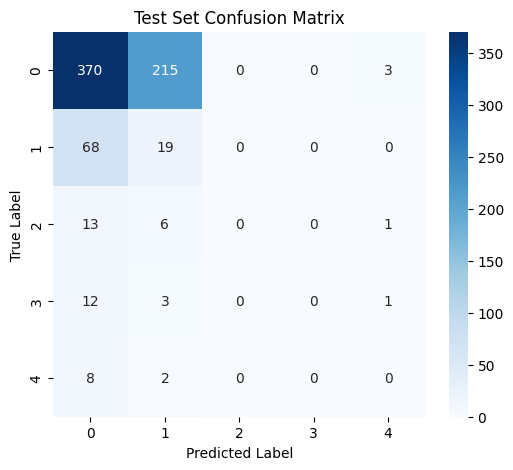

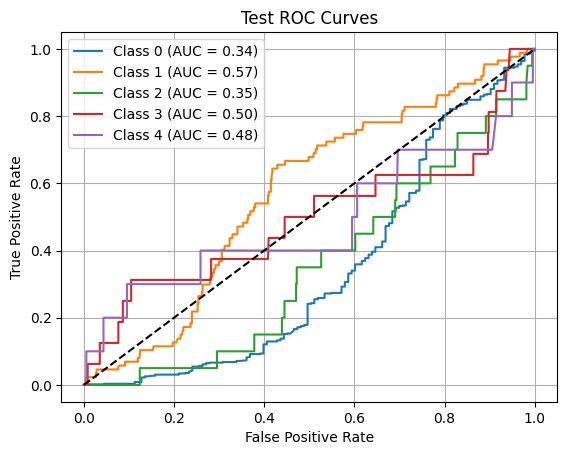

Average AUC (Test): 0.4494
✅ Saved predictions and features to result_phase3_Test_standard.csv
phase4
load data train
build the graph
Total nodes in graph: 5500
User nodes (labels): 5363
Label tensor shape: torch.Size([5363])
train
Epoch 0 | Validation Accuracy: 0.2142
Epoch 10 | Validation Accuracy: 0.6816
Epoch 20 | Validation Accuracy: 0.6890
Epoch 30 | Validation Accuracy: 0.6965
Epoch 40 | Validation Accuracy: 0.7002
Epoch 50 | Validation Accuracy: 0.7002
Epoch 60 | Validation Accuracy: 0.6946
Epoch 70 | Validation Accuracy: 0.6909
Epoch 80 | Validation Accuracy: 0.6909
Epoch 90 | Validation Accuracy: 0.6927
Epoch 100 | Validation Accuracy: 0.6909
Epoch 110 | Validation Accuracy: 0.6946
Epoch 120 | Validation Accuracy: 0.6946
Epoch 130 | Validation Accuracy: 0.6965
Epoch 140 | Validation Accuracy: 0.6983
Epoch 150 | Validation Accuracy: 0.7002
Epoch 160 | Validation Accuracy: 0.6983
Epoch 170 | Validation Accuracy: 0.6983
Epoch 180 | Validation Accuracy: 0.7002
Epoch 190 | Validat

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


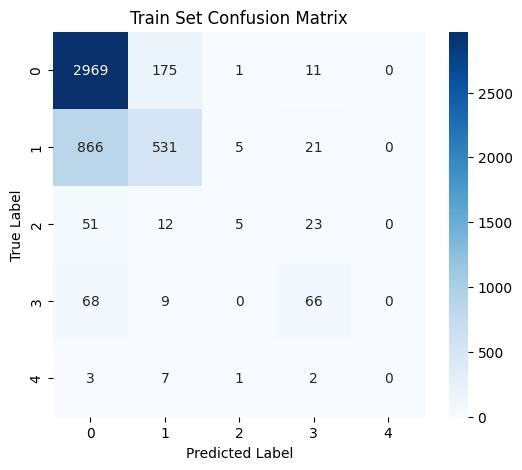

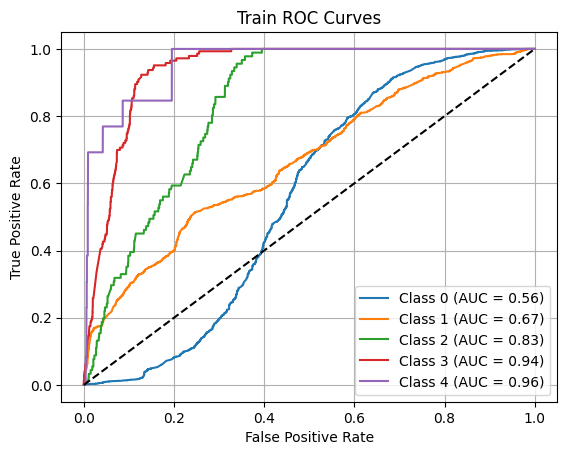

Average AUC (Train): 0.7902
✅ Saved predictions and features to result_phase4_Train_standard.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       351
           1       0.61      0.37      0.46       159
           2       0.00      0.00      0.00        10
           3       0.36      0.25      0.30        16
           4       0.00      0.00      0.00         1

    accuracy                           0.71       537
   macro avg       0.34      0.30      0.31       537
weighted avg       0.68      0.71      0.68       537



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


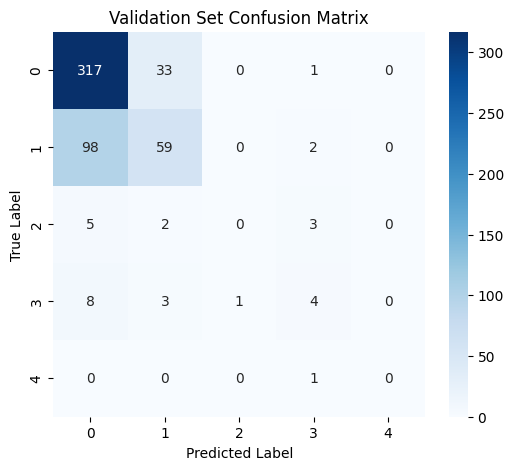

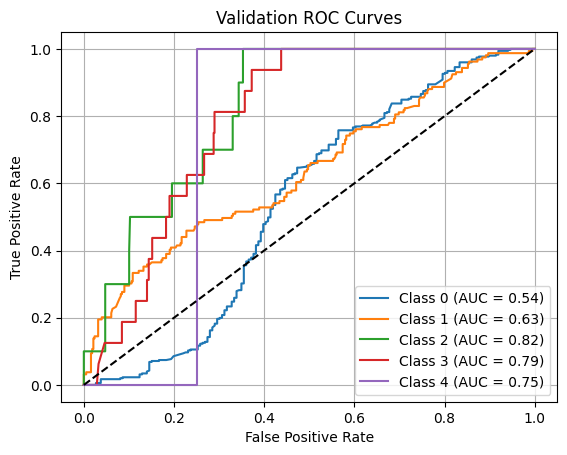

Average AUC (Validation): 0.7083
✅ Saved predictions and features to result_phase4_Validation_standard.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       555
           1       0.08      0.11      0.09        85
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        11

    accuracy                           0.64       687
   macro avg       0.18      0.18      0.18       687
weighted avg       0.65      0.64      0.65       687



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


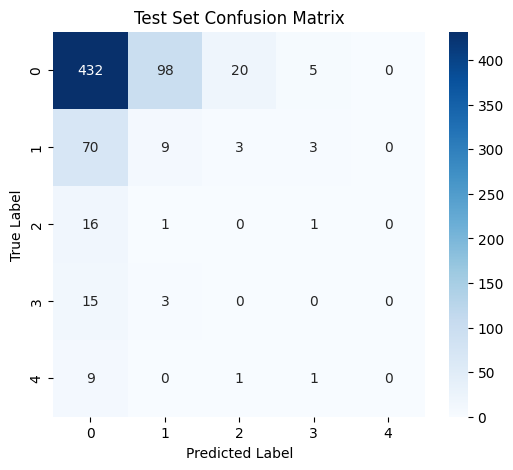

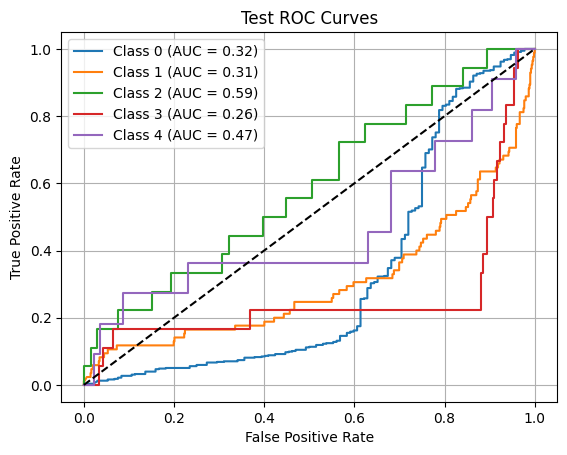

Average AUC (Test): 0.3874
✅ Saved predictions and features to result_phase4_Test_standard.csv


In [18]:
# Lặp qua các phase
for phase in ["phase1", "phase2", "phase3", "phase4"]:
    print(phase)
    phase_ = phase[:-1] + '_' + phase[-1]
    run_pipeline(f'/kaggle/input/final-data/{phase}/user_train_{phase_}_train.csv', 
                    f'/kaggle/input/final-data/{phase}/user_train_{phase_}_test.csv',
                     phase =phase,
                    scale = 'standard')

### Phân phối các nhãn

### Undersampling

In [19]:
# import pandas as pd

# def manual_custom_undersample_decrease(X, y, class_decrease_counts):
#     """
#     Undersample bằng cách giảm bớt một số lượng mẫu xác định cho từng class.

#     Args:
#         X (pd.DataFrame): Features.
#         y (pd.Series): Labels.
#         class_decrease_counts (dict): Dict {class_label: decrease_number}.

#     Returns:
#         (X_resampled, y_resampled): Dữ liệu sau undersample.
#     """
#     df = pd.concat([X, y], axis=1)
#     resampled_parts = []

#     for cls in y.unique():
#         df_cls = df[df[y.name] == cls]
#         if cls in class_decrease_counts:
#             decrease_count = class_decrease_counts[cls]
#             target_count = max(len(df_cls) - decrease_count, 1)  # Đảm bảo ít nhất còn 1 mẫu
#             if len(df_cls) > target_count:
#                 df_cls = df_cls.sample(n=target_count, random_state=42)
#         # Nếu class không cần giảm thì giữ nguyên
#         resampled_parts.append(df_cls)

#     df_resampled = pd.concat(resampled_parts).sample(frac=1, random_state=42)  # shuffle
#     X_resampled = df_resampled.drop(columns=[y.name])
#     y_resampled = df_resampled[y.name]

#     return X_resampled, y_resampled


In [20]:
# for phase in ["phase1", "phase2", "phase3", "phase4"]:
#     phase_ = phase[:-1] + '_' + phase[-1]
#     run_pipeline(f'/kaggle/input/final-data/{phase}/user_train_{phase_}_train.csv', 
#                     f'/kaggle/input/final-data/phase1/user_train_{phase_}_test.csv')

### Oversammpling

In [21]:
# def manual_custom_oversample(X, y, class_increase_counts):
#     """
#     Oversample bằng cách tăng thêm số lượng mẫu xác định cho từng class.

#     Args:
#         X (pd.DataFrame): Features.
#         y (pd.Series): Labels.
#         class_increase_counts (dict): Dict {class_label: increase_number}.

#     Returns:
#         (X_resampled, y_resampled): Dữ liệu sau oversample.
#     """
#     df = pd.concat([X, y], axis=1)
#     resampled_parts = []

#     for cls in y.unique():
#         df_cls = df[df[y.name] == cls]
#         resampled_parts.append(df_cls)  # Ban đầu: dữ liệu gốc

#         if cls in class_increase_counts:
#             increase_count = class_increase_counts[cls]
#             n_repeat = increase_count // len(df_cls)  # số lần nhân bản toàn bộ
#             n_extra = increase_count % len(df_cls)    # thêm bao nhiêu mẫu riêng lẻ

#             # Nhân bản toàn bộ
#             if n_repeat > 0:
#                 resampled_parts.append(pd.concat([df_cls] * n_repeat, ignore_index=True))

#             # Lấy thêm một số mẫu ngẫu nhiên
#             if n_extra > 0:
#                 resampled_parts.append(df_cls.sample(n=n_extra, replace=True, random_state=42))

#     df_resampled = pd.concat(resampled_parts).sample(frac=1, random_state=42)  # shuffle
#     X_resampled = df_resampled.drop(columns=[y.name])
#     y_resampled = df_resampled[y.name]

#     return X_resampled, y_resampled


In [22]:
# for phase in ["phase1", "phase2", "phase3", "phase4"]:
#     process_oversample_phase(phase, scale='standard', metric='f1_macro')

### Tạo mẫu ảo 

# 2. Scale dữ liệu Normalization 

In [23]:
# # Lặp qua các phase
# for phase in ["phase1", "phase2", "phase3", "phase4"]:
#     process_phase(phase, scale ='minmax',metric='f1_macro')

phase1
load data train
build the graph
Total nodes in graph: 10781
User nodes (labels): 10570
Label tensor shape: torch.Size([10570])
train
Epoch 0 | Validation Accuracy: 0.5686
Epoch 10 | Validation Accuracy: 0.6764
Epoch 20 | Validation Accuracy: 0.6755
Epoch 30 | Validation Accuracy: 0.6746
Epoch 40 | Validation Accuracy: 0.6887
Epoch 50 | Validation Accuracy: 0.6878
Epoch 60 | Validation Accuracy: 0.6868
Epoch 70 | Validation Accuracy: 0.6916
Epoch 80 | Validation Accuracy: 0.6973
Epoch 90 | Validation Accuracy: 0.7020
Epoch 100 | Validation Accuracy: 0.6954
Epoch 110 | Validation Accuracy: 0.6897
Epoch 120 | Validation Accuracy: 0.6897
Epoch 130 | Validation Accuracy: 0.6906
Epoch 140 | Validation Accuracy: 0.6935
Epoch 150 | Validation Accuracy: 0.6954
Epoch 160 | Validation Accuracy: 0.6935
Epoch 170 | Validation Accuracy: 0.6944
Epoch 180 | Validation Accuracy: 0.6973
Epoch 190 | Validation Accuracy: 0.6944
Epoch 200 | Validation Accuracy: 0.6963
Epoch 210 | Validation Accuracy

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


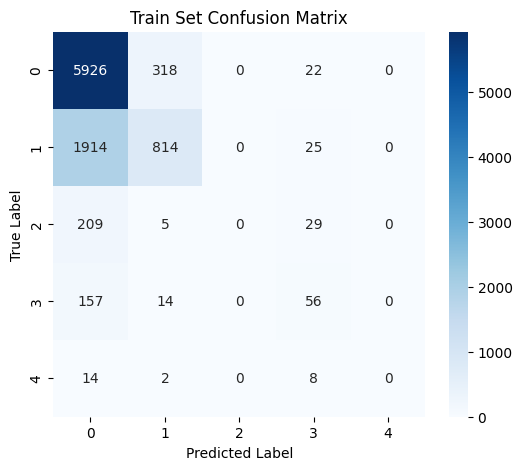

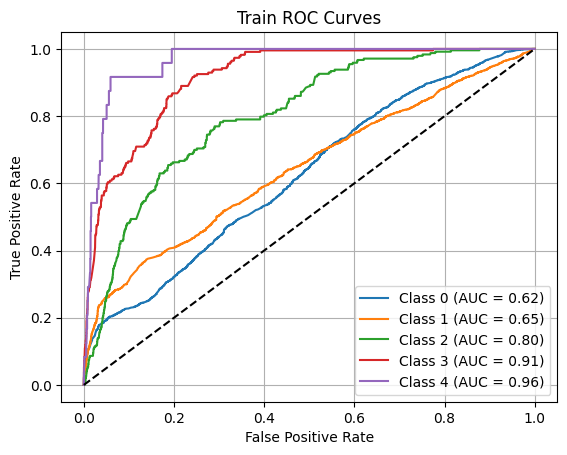

Average AUC (Train): 0.7900
✅ Saved predictions and features to result_phase1_Train_minmax.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       696
           1       0.62      0.23      0.33       306
           2       0.00      0.00      0.00        27
           3       0.20      0.12      0.15        25
           4       0.00      0.00      0.00         3

    accuracy                           0.69      1057
   macro avg       0.31      0.26      0.26      1057
weighted avg       0.65      0.69      0.63      1057



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


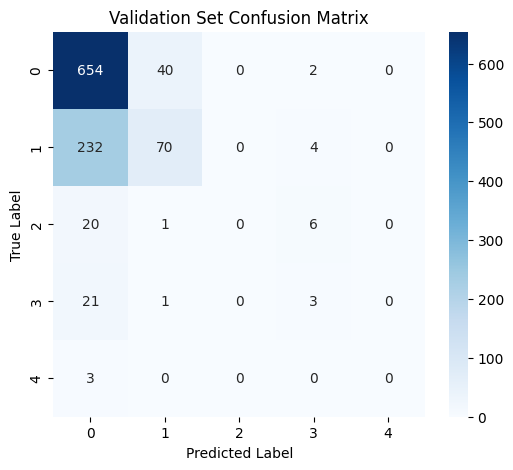

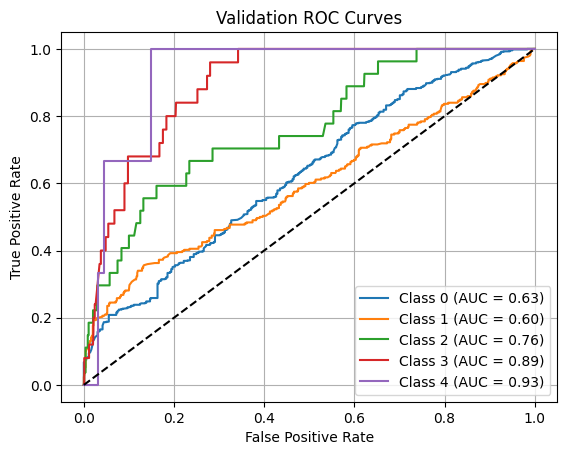

Average AUC (Validation): 0.7615
✅ Saved predictions and features to result_phase1_Validation_minmax.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.56      0.69       616
           1       0.17      0.68      0.28        94
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        10

    accuracy                           0.54       756
   macro avg       0.21      0.25      0.19       756
weighted avg       0.75      0.54      0.60       756



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


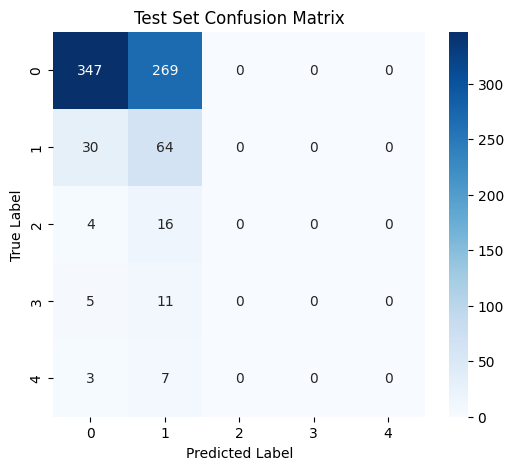

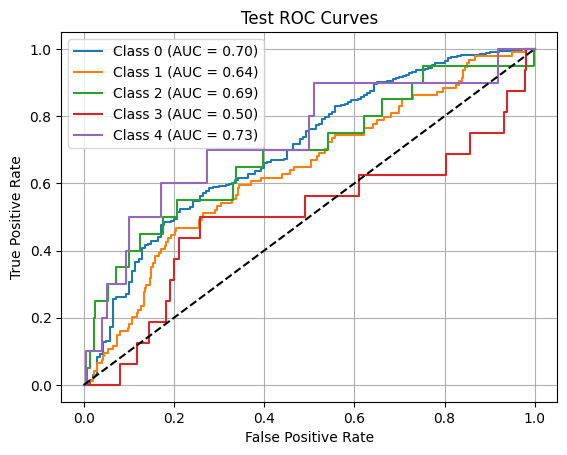

Average AUC (Test): 0.6533
✅ Saved predictions and features to result_phase1_Test_minmax.csv
phase2
load data train
build the graph
Total nodes in graph: 8742
User nodes (labels): 8548
Label tensor shape: torch.Size([8548])
train
Epoch 0 | Validation Accuracy: 0.1883
Epoch 10 | Validation Accuracy: 0.6573
Epoch 20 | Validation Accuracy: 0.6573
Epoch 30 | Validation Accuracy: 0.6561
Epoch 40 | Validation Accuracy: 0.6608
Epoch 50 | Validation Accuracy: 0.6620
Epoch 60 | Validation Accuracy: 0.6632
Epoch 70 | Validation Accuracy: 0.6667
Epoch 80 | Validation Accuracy: 0.6667
Epoch 90 | Validation Accuracy: 0.6678
Epoch 100 | Validation Accuracy: 0.6690
Epoch 110 | Validation Accuracy: 0.6678
Epoch 120 | Validation Accuracy: 0.6713
Epoch 130 | Validation Accuracy: 0.6854
Epoch 140 | Validation Accuracy: 0.6819
Epoch 150 | Validation Accuracy: 0.6819
Epoch 160 | Validation Accuracy: 0.6830
Epoch 170 | Validation Accuracy: 0.6819
Epoch 180 | Validation Accuracy: 0.6830
Epoch 190 | Validatio

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


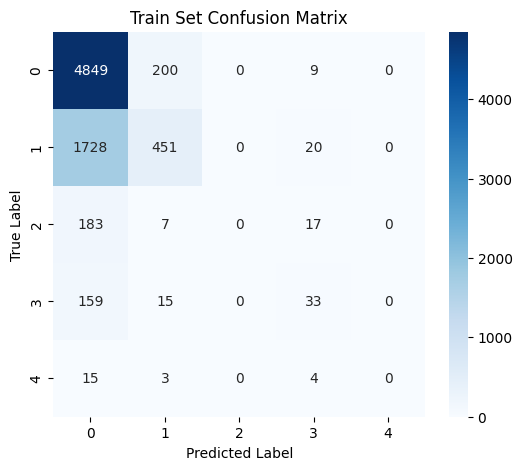

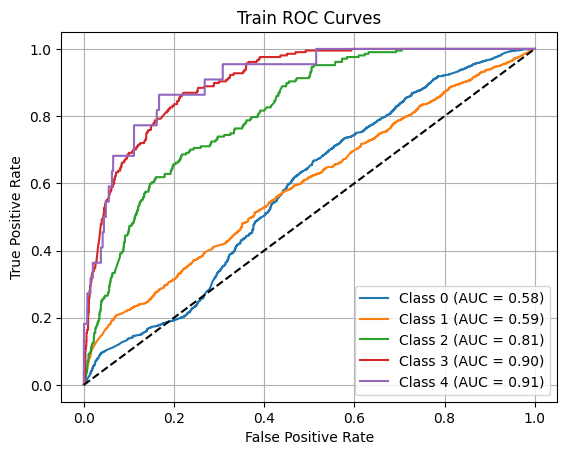

Average AUC (Train): 0.7599
✅ Saved predictions and features to result_phase2_Train_minmax.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.70      0.97      0.81       562
           1       0.75      0.20      0.32       244
           2       0.00      0.00      0.00        23
           3       0.43      0.13      0.20        23
           4       0.00      0.00      0.00         3

    accuracy                           0.70       855
   macro avg       0.37      0.26      0.27       855
weighted avg       0.68      0.70      0.63       855



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


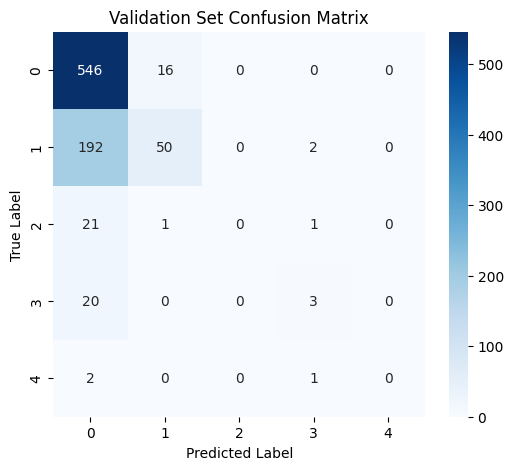

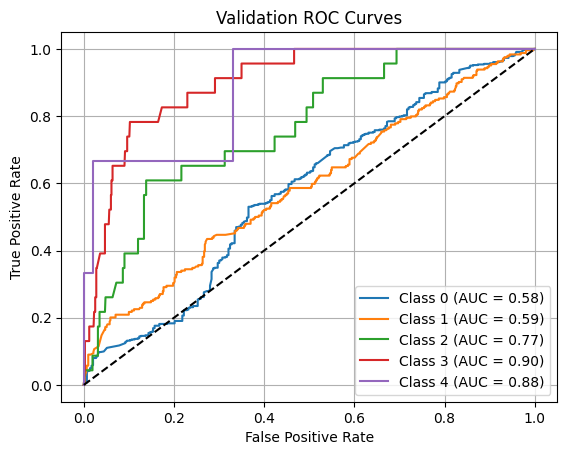

Average AUC (Validation): 0.7434
✅ Saved predictions and features to result_phase2_Validation_minmax.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       609
           1       0.24      0.12      0.16        92
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        10

    accuracy                           0.79       746
   macro avg       0.21      0.21      0.21       746
weighted avg       0.71      0.79      0.74       746



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


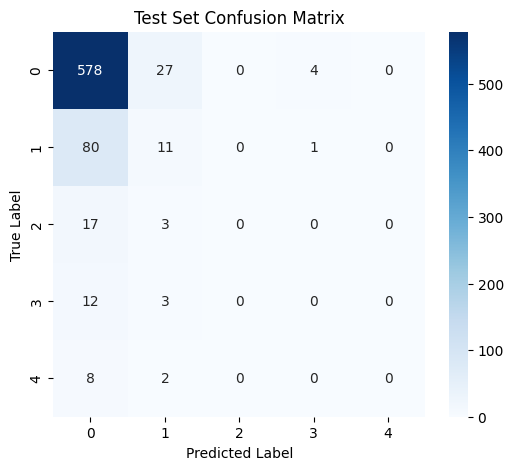

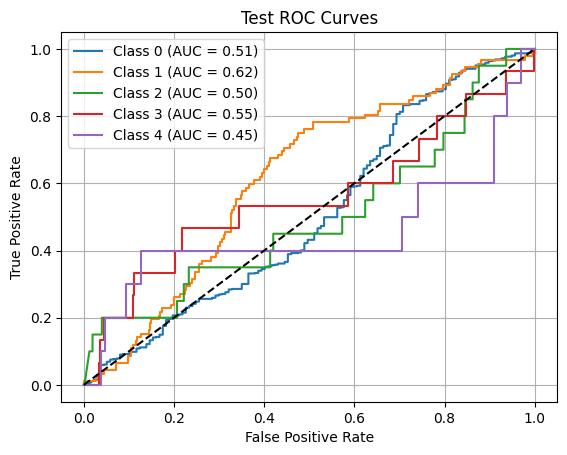

Average AUC (Test): 0.5253
✅ Saved predictions and features to result_phase2_Test_minmax.csv
phase3
load data train
build the graph
Total nodes in graph: 7970
User nodes (labels): 7803
Label tensor shape: torch.Size([7803])
train
Epoch 0 | Validation Accuracy: 0.0038
Epoch 10 | Validation Accuracy: 0.6569
Epoch 20 | Validation Accuracy: 0.6569
Epoch 30 | Validation Accuracy: 0.6569
Epoch 40 | Validation Accuracy: 0.6581
Epoch 50 | Validation Accuracy: 0.6581
Epoch 60 | Validation Accuracy: 0.6581
Epoch 70 | Validation Accuracy: 0.6581
Epoch 80 | Validation Accuracy: 0.6607
Epoch 90 | Validation Accuracy: 0.6722
Epoch 100 | Validation Accuracy: 0.6722
Epoch 110 | Validation Accuracy: 0.6722
Epoch 120 | Validation Accuracy: 0.6722
Epoch 130 | Validation Accuracy: 0.6761
Epoch 140 | Validation Accuracy: 0.6773
Epoch 150 | Validation Accuracy: 0.6761
Epoch 160 | Validation Accuracy: 0.6748
Epoch 170 | Validation Accuracy: 0.6761
Epoch 180 | Validation Accuracy: 0.6773
Epoch 190 | Validatio

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


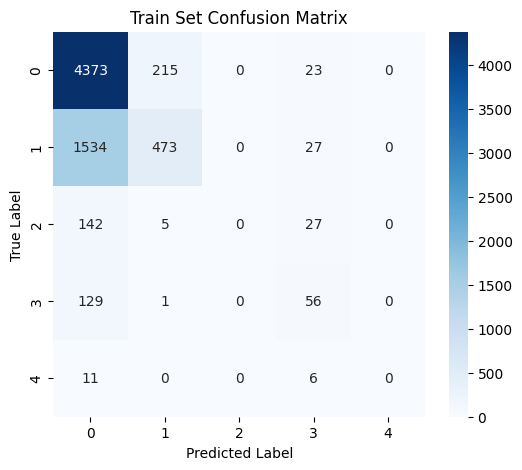

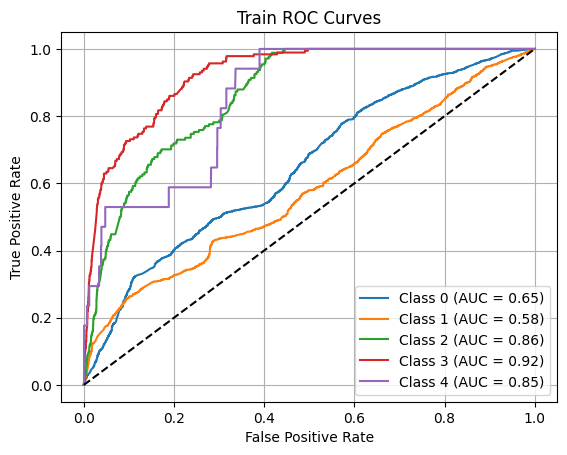

Average AUC (Train): 0.7728
✅ Saved predictions and features to result_phase3_Train_minmax.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.71      0.96      0.82       513
           1       0.73      0.24      0.36       226
           2       0.00      0.00      0.00        19
           3       0.40      0.29      0.33        21
           4       0.00      0.00      0.00         2

    accuracy                           0.71       781
   macro avg       0.37      0.30      0.30       781
weighted avg       0.69      0.71      0.65       781



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


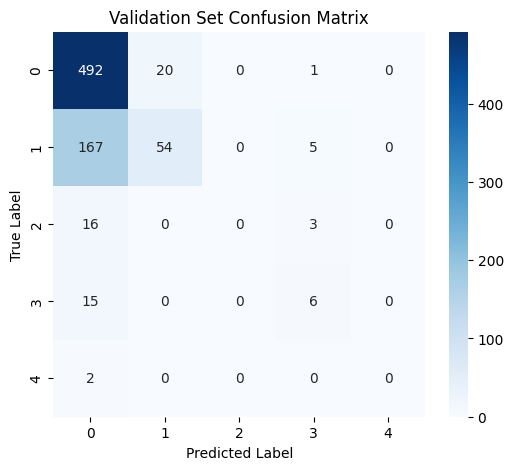

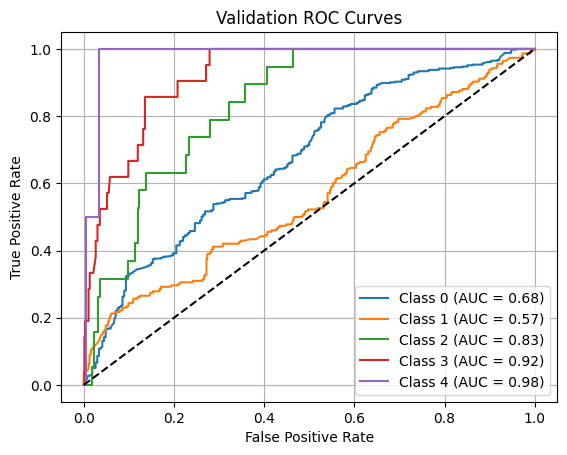

Average AUC (Validation): 0.7951
✅ Saved predictions and features to result_phase3_Validation_minmax.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       588
           1       0.08      0.06      0.07        87
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        10

    accuracy                           0.73       721
   macro avg       0.18      0.19      0.18       721
weighted avg       0.67      0.73      0.70       721



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


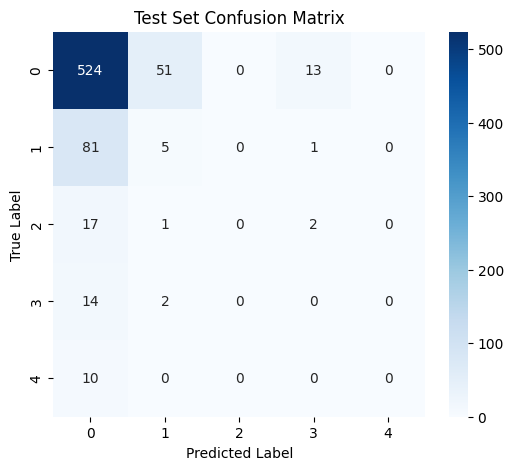

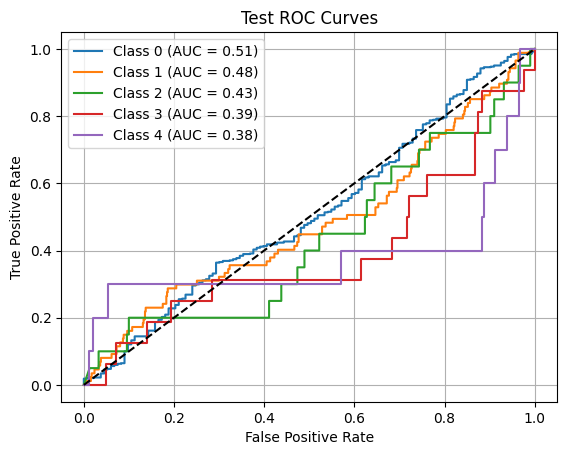

Average AUC (Test): 0.4393
✅ Saved predictions and features to result_phase3_Test_minmax.csv
phase4
load data train
build the graph
Total nodes in graph: 5500
User nodes (labels): 5363
Label tensor shape: torch.Size([5363])
train
Epoch 0 | Validation Accuracy: 0.3911
Epoch 10 | Validation Accuracy: 0.6536
Epoch 20 | Validation Accuracy: 0.6555
Epoch 30 | Validation Accuracy: 0.6462
Epoch 40 | Validation Accuracy: 0.6480
Epoch 50 | Validation Accuracy: 0.6480
Epoch 60 | Validation Accuracy: 0.6518
Epoch 70 | Validation Accuracy: 0.6443
Epoch 80 | Validation Accuracy: 0.6797
Epoch 90 | Validation Accuracy: 0.6797
Epoch 100 | Validation Accuracy: 0.6797
Epoch 110 | Validation Accuracy: 0.6834
Epoch 120 | Validation Accuracy: 0.6909
Epoch 130 | Validation Accuracy: 0.6909
Epoch 140 | Validation Accuracy: 0.6853
Epoch 150 | Validation Accuracy: 0.6890
Epoch 160 | Validation Accuracy: 0.6909
Epoch 170 | Validation Accuracy: 0.6853
Epoch 180 | Validation Accuracy: 0.7020
Epoch 190 | Validatio

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


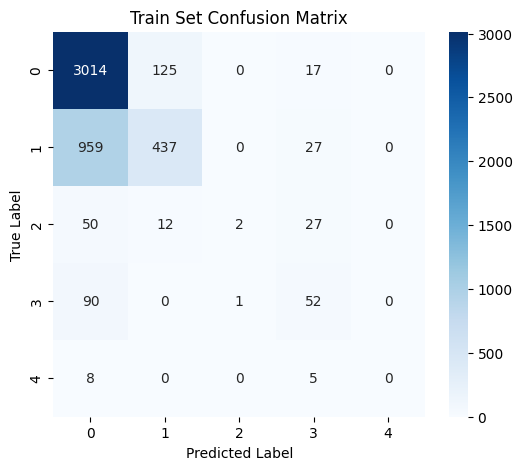

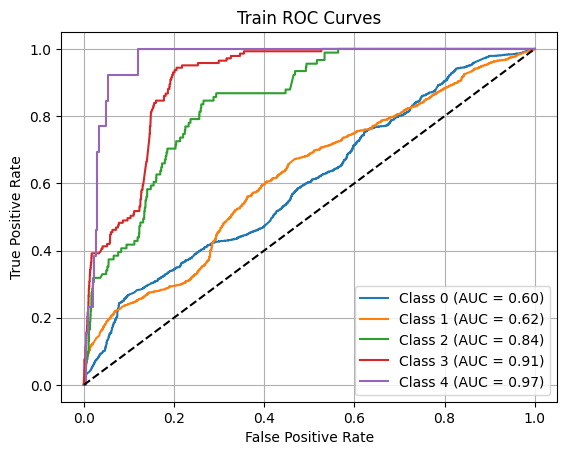

Average AUC (Train): 0.7874
✅ Saved predictions and features to result_phase4_Train_minmax.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.72      0.91      0.81       351
           1       0.63      0.30      0.41       159
           2       0.00      0.00      0.00        10
           3       0.53      0.56      0.55        16
           4       0.00      0.00      0.00         1

    accuracy                           0.70       537
   macro avg       0.38      0.36      0.35       537
weighted avg       0.68      0.70      0.67       537



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


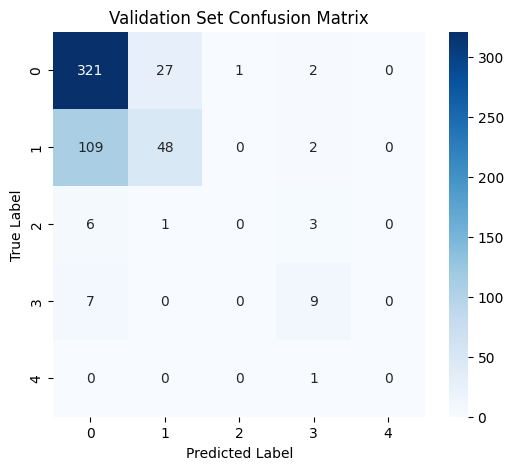

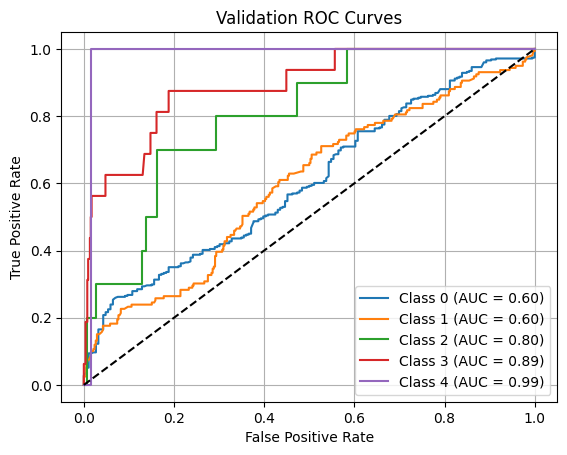

Average AUC (Validation): 0.7758
✅ Saved predictions and features to result_phase4_Validation_minmax.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.51      0.65       555
           1       0.18      0.69      0.28        85
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        11

    accuracy                           0.50       687
   macro avg       0.21      0.24      0.19       687
weighted avg       0.75      0.50      0.56       687



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


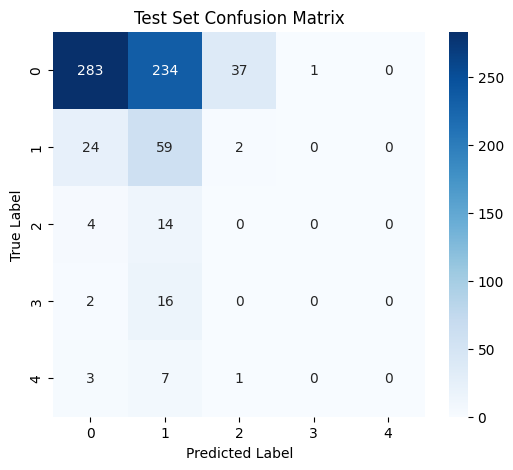

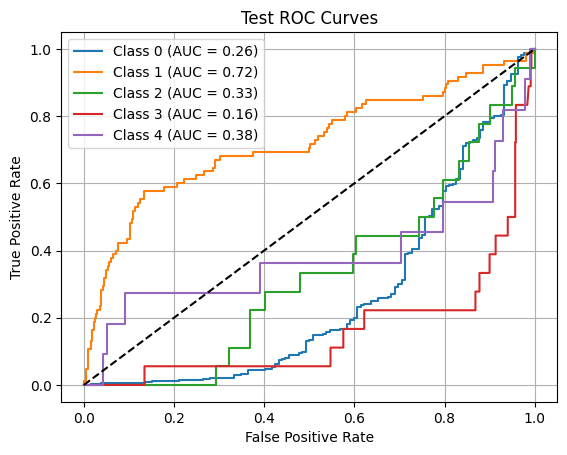

Average AUC (Test): 0.3700
✅ Saved predictions and features to result_phase4_Test_minmax.csv


In [24]:
# Lặp qua các phase
for phase in ["phase1", "phase2", "phase3", "phase4"]:
    print(phase)
    phase_ = phase[:-1] + '_' + phase[-1]
    run_pipeline(f'/kaggle/input/final-data/{phase}/user_train_{phase_}_train.csv', 
                    f'/kaggle/input/final-data/{phase}/user_train_{phase_}_test.csv',
                 phase =phase,
                scale = 'minmax')

# 3. Scale dữ liệu theo Robust 

phase1
load data train
build the graph
Total nodes in graph: 10781
User nodes (labels): 10570
Label tensor shape: torch.Size([10570])
train
Epoch 0 | Validation Accuracy: 0.1523
Epoch 10 | Validation Accuracy: 0.6452
Epoch 20 | Validation Accuracy: 0.6594
Epoch 30 | Validation Accuracy: 0.6670
Epoch 40 | Validation Accuracy: 0.6679
Epoch 50 | Validation Accuracy: 0.6783
Epoch 60 | Validation Accuracy: 0.6708
Epoch 70 | Validation Accuracy: 0.6689
Epoch 80 | Validation Accuracy: 0.6764
Epoch 90 | Validation Accuracy: 0.6783
Epoch 100 | Validation Accuracy: 0.6774
Epoch 110 | Validation Accuracy: 0.6764
Epoch 120 | Validation Accuracy: 0.6755
Epoch 130 | Validation Accuracy: 0.6774
Epoch 140 | Validation Accuracy: 0.6764
Epoch 150 | Validation Accuracy: 0.6764
Epoch 160 | Validation Accuracy: 0.6764
Epoch 170 | Validation Accuracy: 0.6755
Epoch 180 | Validation Accuracy: 0.6774
Epoch 190 | Validation Accuracy: 0.6774
Epoch 200 | Validation Accuracy: 0.6783
Epoch 210 | Validation Accuracy

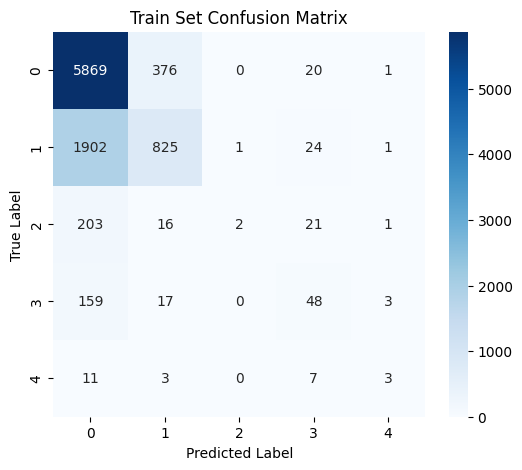

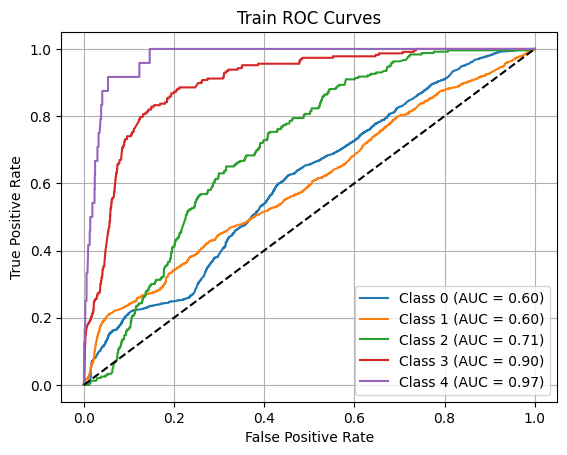

Average AUC (Train): 0.7560
✅ Saved predictions and features to result_phase1_Train_robust.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.71      0.94      0.81       696
           1       0.67      0.25      0.36       306
           2       0.00      0.00      0.00        27
           3       0.33      0.16      0.22        25
           4       0.00      0.00      0.00         3

    accuracy                           0.70      1057
   macro avg       0.34      0.27      0.28      1057
weighted avg       0.67      0.70      0.64      1057



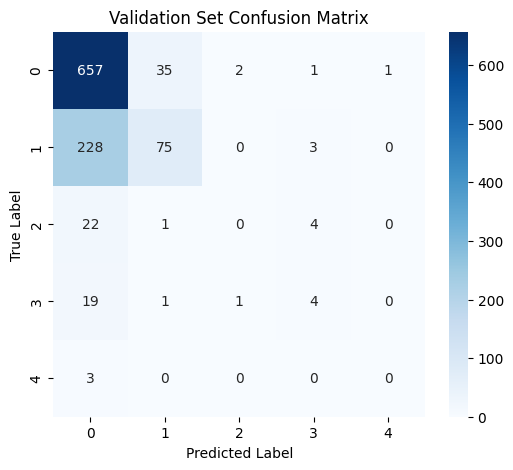

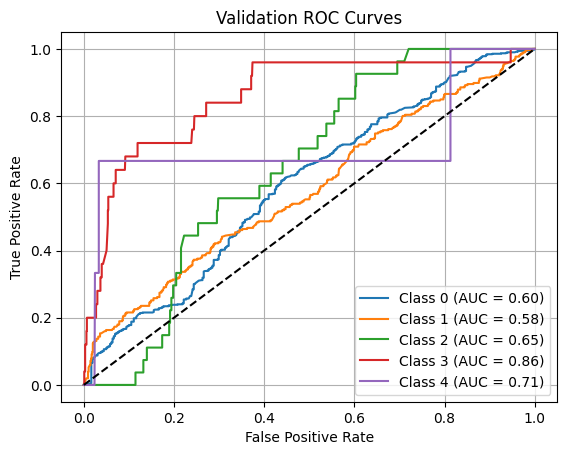

Average AUC (Validation): 0.6777
✅ Saved predictions and features to result_phase1_Validation_robust.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       616
           1       0.33      0.17      0.22        94
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        10

    accuracy                           0.79       756
   macro avg       0.23      0.22      0.22       756
weighted avg       0.72      0.79      0.75       756



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


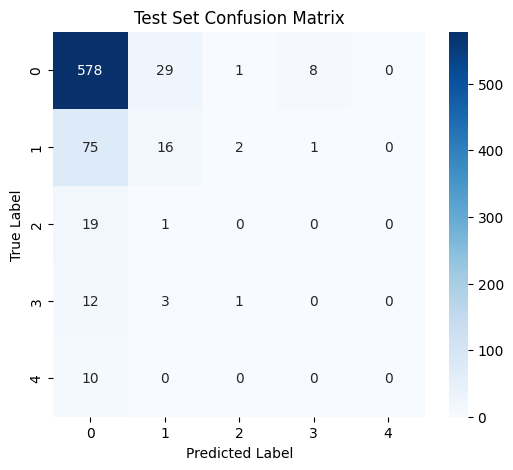

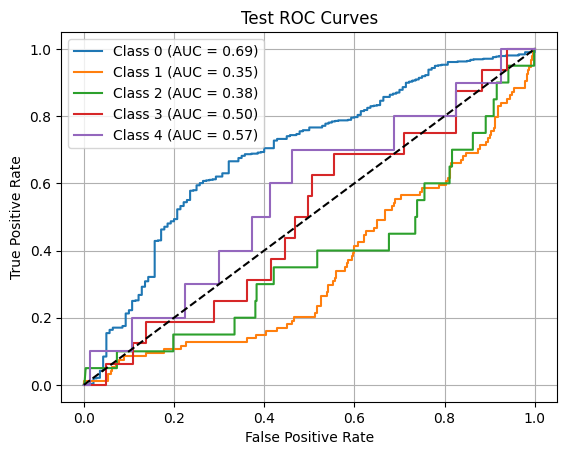

Average AUC (Test): 0.4970
✅ Saved predictions and features to result_phase1_Test_robust.csv
phase2
load data train
build the graph
Total nodes in graph: 8742
User nodes (labels): 8548
Label tensor shape: torch.Size([8548])
train
Epoch 0 | Validation Accuracy: 0.0936
Epoch 10 | Validation Accuracy: 0.5497
Epoch 20 | Validation Accuracy: 0.6538
Epoch 30 | Validation Accuracy: 0.6608
Epoch 40 | Validation Accuracy: 0.6409
Epoch 50 | Validation Accuracy: 0.6456
Epoch 60 | Validation Accuracy: 0.6538
Epoch 70 | Validation Accuracy: 0.6561
Epoch 80 | Validation Accuracy: 0.6608
Epoch 90 | Validation Accuracy: 0.6561
Epoch 100 | Validation Accuracy: 0.6596
Epoch 110 | Validation Accuracy: 0.6632
Epoch 120 | Validation Accuracy: 0.6655
Epoch 130 | Validation Accuracy: 0.6690
Epoch 140 | Validation Accuracy: 0.6713
Epoch 150 | Validation Accuracy: 0.6690
Epoch 160 | Validation Accuracy: 0.6737
Epoch 170 | Validation Accuracy: 0.6760
Epoch 180 | Validation Accuracy: 0.6784
Epoch 190 | Validatio

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


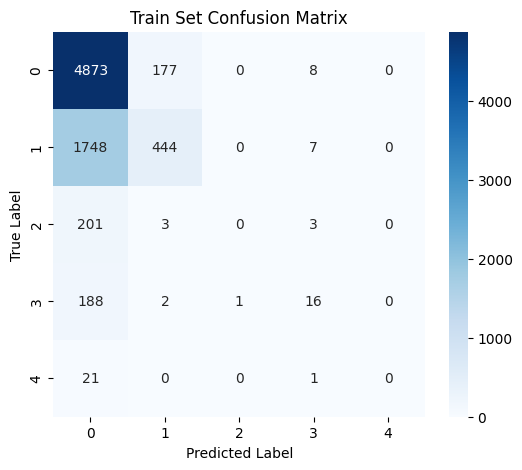

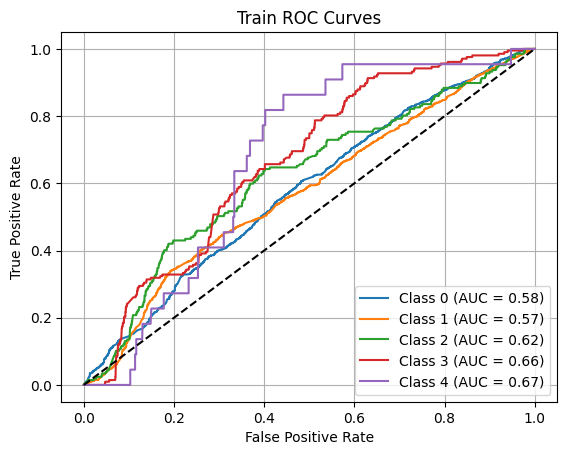

Average AUC (Train): 0.6221
✅ Saved predictions and features to result_phase2_Train_robust.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.69      0.96      0.80       562
           1       0.66      0.18      0.29       244
           2       0.00      0.00      0.00        23
           3       0.67      0.09      0.15        23
           4       0.00      0.00      0.00         3

    accuracy                           0.69       855
   macro avg       0.40      0.25      0.25       855
weighted avg       0.66      0.69      0.61       855



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


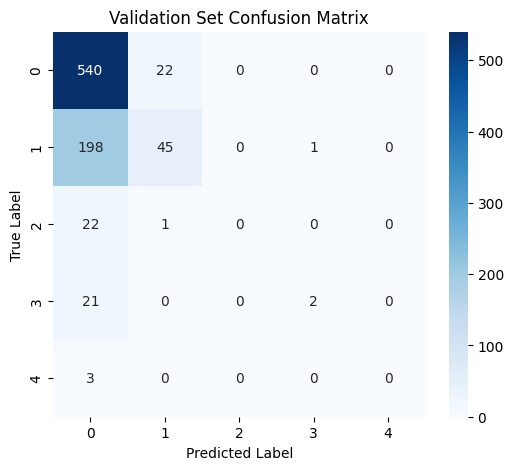

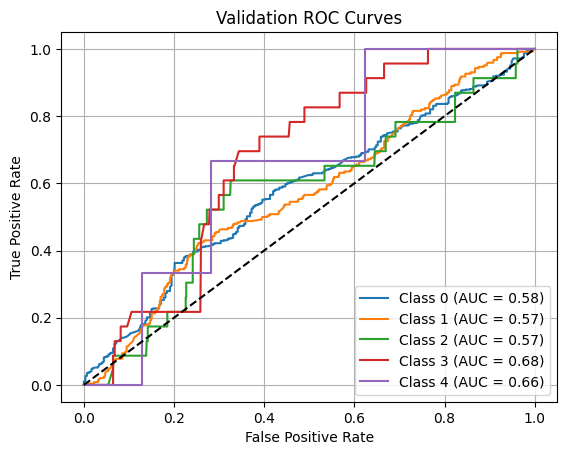

Average AUC (Validation): 0.6094
✅ Saved predictions and features to result_phase2_Validation_robust.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       609
           1       0.20      0.08      0.11        92
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        10

    accuracy                           0.77       746
   macro avg       0.21      0.20      0.20       746
weighted avg       0.71      0.77      0.73       746



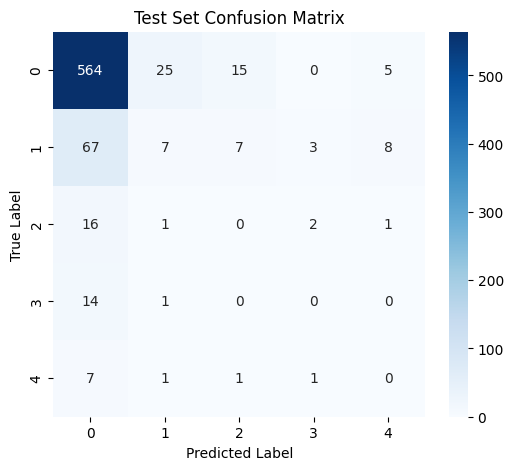

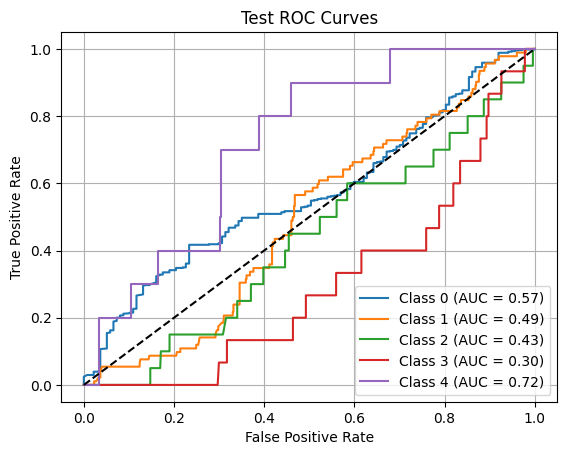

Average AUC (Test): 0.5021
✅ Saved predictions and features to result_phase2_Test_robust.csv
phase3
load data train
build the graph
Total nodes in graph: 7970
User nodes (labels): 7803
Label tensor shape: torch.Size([7803])
train
Epoch 0 | Validation Accuracy: 0.0768
Epoch 10 | Validation Accuracy: 0.6108
Epoch 20 | Validation Accuracy: 0.6440
Epoch 30 | Validation Accuracy: 0.6530
Epoch 40 | Validation Accuracy: 0.6748
Epoch 50 | Validation Accuracy: 0.6799
Epoch 60 | Validation Accuracy: 0.6850
Epoch 70 | Validation Accuracy: 0.6850
Epoch 80 | Validation Accuracy: 0.6889
Epoch 90 | Validation Accuracy: 0.6901
Epoch 100 | Validation Accuracy: 0.6927
Epoch 110 | Validation Accuracy: 0.6914
Epoch 120 | Validation Accuracy: 0.6889
Epoch 130 | Validation Accuracy: 0.6914
Epoch 140 | Validation Accuracy: 0.6889
Epoch 150 | Validation Accuracy: 0.6876
Epoch 160 | Validation Accuracy: 0.6927
Epoch 170 | Validation Accuracy: 0.6901
Epoch 180 | Validation Accuracy: 0.6889
Epoch 190 | Validatio

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


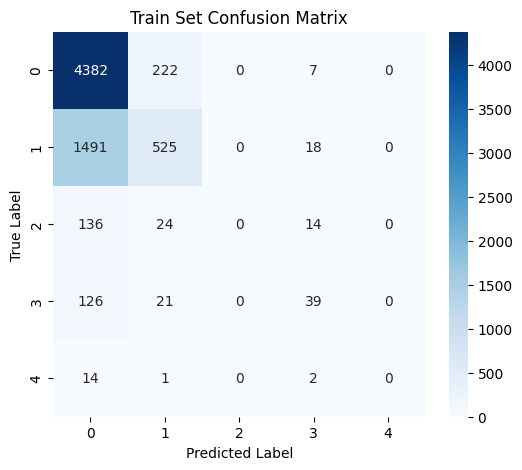

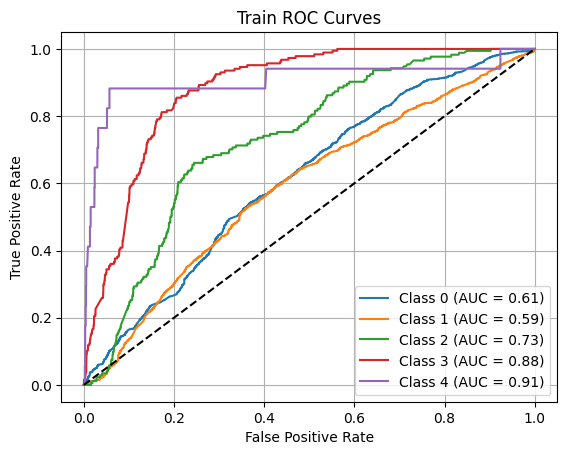

Average AUC (Train): 0.7441
✅ Saved predictions and features to result_phase3_Train_robust.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       513
           1       0.60      0.27      0.38       226
           2       0.00      0.00      0.00        19
           3       0.18      0.10      0.12        21
           4       0.00      0.00      0.00         2

    accuracy                           0.70       781
   macro avg       0.30      0.26      0.26       781
weighted avg       0.65      0.70      0.65       781



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


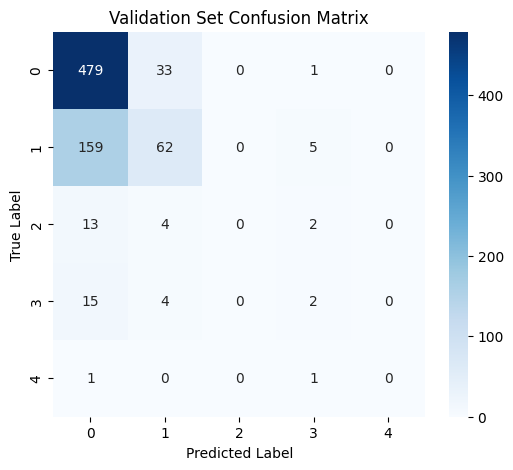

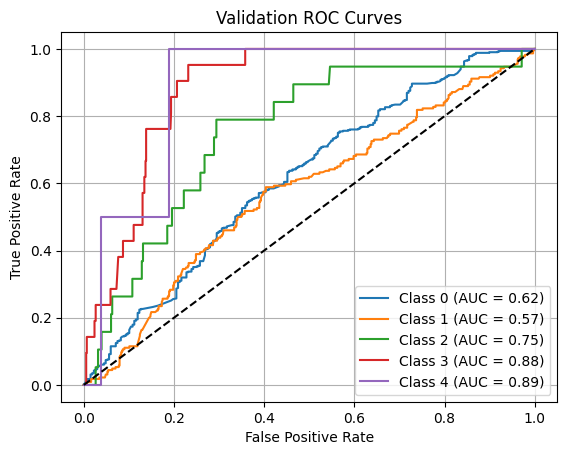

Average AUC (Validation): 0.7421
✅ Saved predictions and features to result_phase3_Validation_robust.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       588
           1       0.08      0.07      0.08        87
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        10

    accuracy                           0.74       721
   macro avg       0.18      0.19      0.19       721
weighted avg       0.67      0.74      0.70       721



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


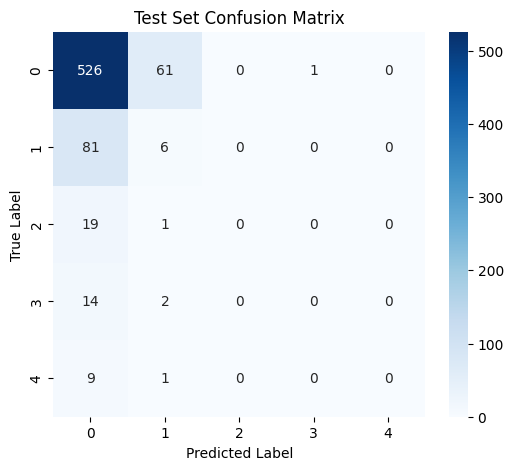

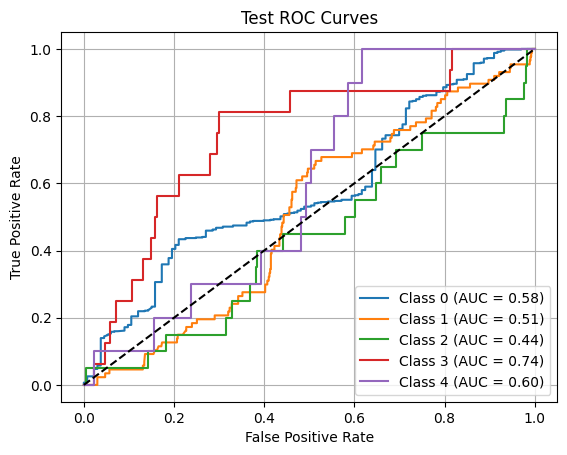

Average AUC (Test): 0.5719
✅ Saved predictions and features to result_phase3_Test_robust.csv
phase4
load data train
build the graph
Total nodes in graph: 5500
User nodes (labels): 5363
Label tensor shape: torch.Size([5363])
train
Epoch 0 | Validation Accuracy: 0.2291
Epoch 10 | Validation Accuracy: 0.6127
Epoch 20 | Validation Accuracy: 0.6462
Epoch 30 | Validation Accuracy: 0.6629
Epoch 40 | Validation Accuracy: 0.6592
Epoch 50 | Validation Accuracy: 0.6629
Epoch 60 | Validation Accuracy: 0.6778
Epoch 70 | Validation Accuracy: 0.6797
Epoch 80 | Validation Accuracy: 0.6760
Epoch 90 | Validation Accuracy: 0.6723
Epoch 100 | Validation Accuracy: 0.6704
Epoch 110 | Validation Accuracy: 0.6741
Epoch 120 | Validation Accuracy: 0.6797
Epoch 130 | Validation Accuracy: 0.6797
Epoch 140 | Validation Accuracy: 0.6834
Epoch 150 | Validation Accuracy: 0.6816
Epoch 160 | Validation Accuracy: 0.6834
Epoch 170 | Validation Accuracy: 0.6853
Epoch 180 | Validation Accuracy: 0.6834
Epoch 190 | Validatio

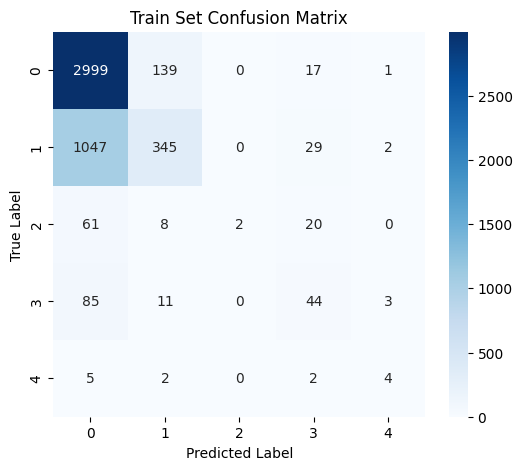

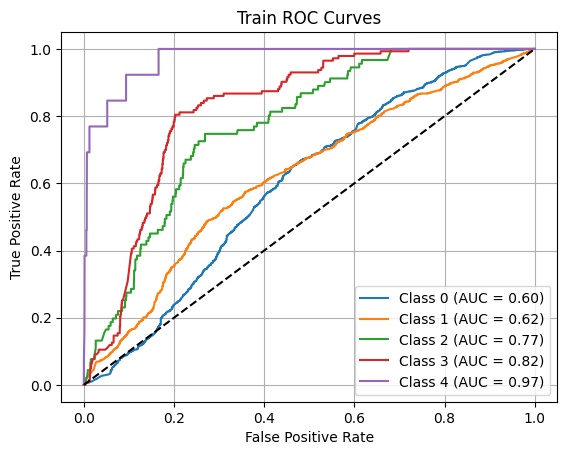

Average AUC (Train): 0.7583
✅ Saved predictions and features to result_phase4_Train_robust.csv

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.71      0.94      0.81       351
           1       0.60      0.22      0.32       159
           2       0.00      0.00      0.00        10
           3       0.46      0.38      0.41        16
           4       0.00      0.00      0.00         1

    accuracy                           0.69       537
   macro avg       0.35      0.31      0.31       537
weighted avg       0.65      0.69      0.63       537



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


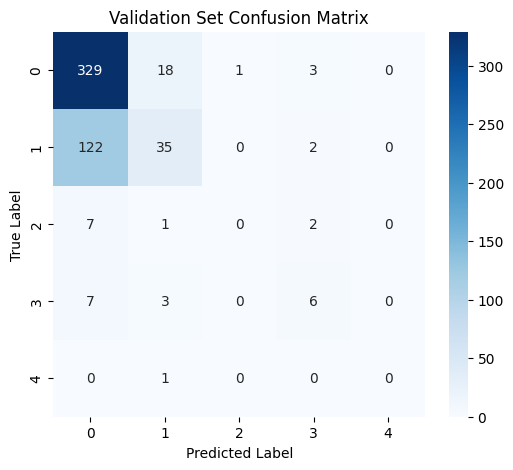

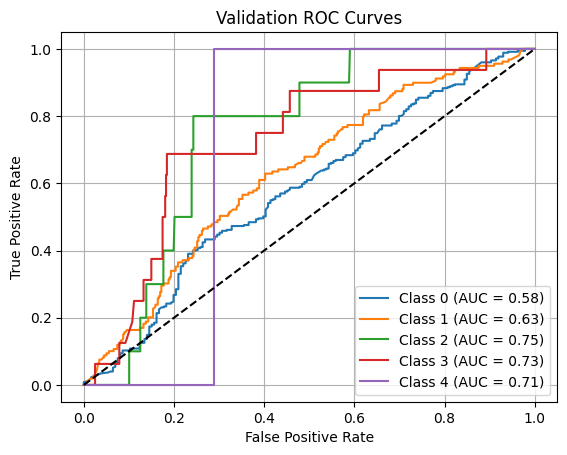

Average AUC (Validation): 0.6799
✅ Saved predictions and features to result_phase4_Validation_robust.csv

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       555
           1       0.03      0.01      0.02        85
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        11

    accuracy                           0.75       687
   macro avg       0.17      0.19      0.18       687
weighted avg       0.66      0.75      0.70       687



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


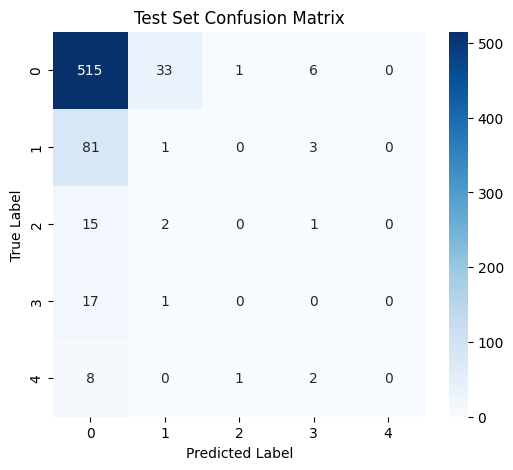

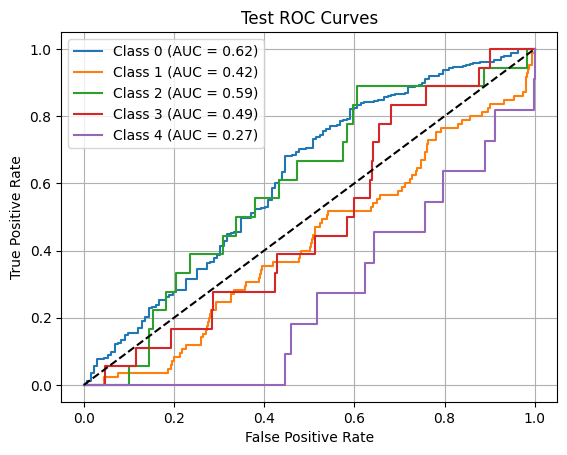

Average AUC (Test): 0.4776
✅ Saved predictions and features to result_phase4_Test_robust.csv


In [25]:
# Lặp qua các phase
for phase in ["phase1", "phase2", "phase3", "phase4"]:
    print(phase)
    phase_ = phase[:-1] + '_' + phase[-1]
    run_pipeline(f'/kaggle/input/final-data/{phase}/user_train_{phase_}_train.csv', 
                    f'/kaggle/input/final-data/{phase}/user_train_{phase_}_test.csv',
                 phase =phase,
                scale = 'robust')

# 4. Scale dữ liệu theo Log

In [26]:
# # Lặp qua các phase
# for phase in ["phase1", "phase2", "phase3", "phase4"]:
#     phase_ = phase[:-1] + '_' + phase[-1]
#     run_pipeline(f'/kaggle/input/final-data/{phase}/user_train_{phase_}_train.csv', 
#                     f'/kaggle/input/final-data/phase1/user_train_{phase_}_test.csv',
#                 scale = 'log')